In [81]:
import requests, re
import numpy as np
from lxml import etree
import xml.etree.ElementTree as ET
from tqdm import tqdm_notebook as tqdm
import zipfile, urllib
import pandas as pd
pd.set_option('display.max_columns', None)
from scipy import stats
import collections
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
def get_data_urls(year_range=None):
    """
        Args:
            year_range - List: Parameter will take either a 2 value list or `None`. If parameter is a list, results will be restricted to years less than the first value and greater than the second.
                Example: [2003, 2010] - Files returned : 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010
                Example: [2003, 2003] - Files returned : 2003
        Returns:
            all_data_links - List: List of links filtered by the requested `year_range`
    """
    url_base = 'https://exporter.nih.gov'
    url_search = url_base + '/ExPORTER_Catalog.aspx'

    url_text = requests.get(url_search).text

    parser = etree.XMLParser(recover=True)
    root = ET.fromstring(url_text, parser=parser)
    
    #### I stole this code from the internet but it will replace the prefix that gets added
    #### There's probably a better way to do this
    for elem in root.getiterator():
        if not hasattr(elem.tag, 'find'): continue
        i = elem.tag.find('}')
        if i >= 0:
            elem.tag = elem.tag[i+1:]
    ####
    data_2019 = [i.get('href') for i in root.findall('.//tr[@class="row_bg"]/td//a')]
    data_2019 = [i for i in data_2019  if ('XMLData' in i) and ('2019' in i)]
    data_2019 = [url_base + '/' + i for i in data_2019]
    
    
    ### Range + 1900 goes from 1985 to 2018    
    years = [1900 + i for i in range(85,119)]
    years = sorted(years, reverse = True)
    fy_links = [f'https://exporter.nih.gov/XMLData/final/RePORTER_PRJ_X_FY{year}.zip' for year in years]

    all_data_links = data_2019 + fy_links
    ### Make a copy because we modifying in place ya'll
    all_data_loop = all_data_links.copy()
    if year_range is not None:
        for link in all_data_loop:
            link_year = re.search('FY.{4}.*\.zip', link).group()
            ### Remove '.zip' then remove any '_\d' stuff that 2019 files have
            link_year = link_year.split('.')[0].split('_')[0]
            ### Remove 'FY'
            link_year = link_year[2:]
            link_year = int(link_year)
            if (link_year < year_range[0]) or (link_year > year_range[1]):
                ### modifying in place ya'll
                all_data_links.remove(link)
                
    return all_data_links

In [4]:
def extract_xml_from_zip(zip_links, out_format = 'dict'):
    """
    Function takes in a link to a zip file with an XML inside and will return a data structure containing that data.
    Data structure can be either a dictionary or a dataframe.
    
    """
    if isinstance(zip_links, str):
        zip_links = [zip_links]
    projects_dict = {}
    for zip_link in zip_links:
        zip_file = zip_link.split('/')[-1]
        file_name = zip_file.split('.')[0]
        xml_name = file_name + '.xml'
        with zipfile.ZipFile(urllib.request.urlretrieve(zip_link, filename=None)[0], 'r') as archive:
            xml_data = archive.read(xml_name)
        rows = []
        root = ET.fromstring(xml_data)

        
        for project in root.findall('./row'):
            project_dict = {}
            for column in project.findall('./'):
                column_header = column.tag.lower()
                if column_header == 'project_termsx':
                    column_header = 'project_terms'
                if column_header == 'project_terms':
                    project_dict['project_terms'] = [i.text for i in column.findall('./')]
                else:
                    project_dict[column_header] = column.text
                
            project_dict['data_source'] = zip_link
            projects_dict[project_dict['application_id']] = project_dict
    
    if out_format.lower() == 'df':
        projects_dict = pd.DataFrame.from_dict(projects_dict, orient='index')
    return projects_dict

In [6]:
urls = get_data_urls([2019, 2019])
urls

['https://exporter.nih.gov/XMLData/final/RePORTER_PRJ_X_FY2019_053.zip',
 'https://exporter.nih.gov/XMLData/final/RePORTER_PRJ_X_FY2019_052.zip',
 'https://exporter.nih.gov/XMLData/final/RePORTER_PRJ_X_FY2019_051.zip',
 'https://exporter.nih.gov/XMLData/final/RePORTER_PRJ_X_FY2019_050.zip',
 'https://exporter.nih.gov/XMLData/final/RePORTER_PRJ_X_FY2019_049.zip',
 'https://exporter.nih.gov/XMLData/final/RePORTER_PRJ_X_FY2019_048.zip',
 'https://exporter.nih.gov/XMLData/final/RePORTER_PRJ_X_FY2019_047.zip',
 'https://exporter.nih.gov/XMLData/final/RePORTER_PRJ_X_FY2019_046.zip',
 'https://exporter.nih.gov/XMLData/final/RePORTER_PRJ_X_FY2019_045.zip',
 'https://exporter.nih.gov/XMLData/final/RePORTER_PRJ_X_FY2019_044.zip',
 'https://exporter.nih.gov/XMLData/final/RePORTER_PRJ_X_FY2019_043.zip',
 'https://exporter.nih.gov/XMLData/final/RePORTER_PRJ_X_FY2019_042.zip',
 'https://exporter.nih.gov/XMLData/final/RePORTER_PRJ_X_FY2019_041.zip',
 'https://exporter.nih.gov/XMLData/final/RePORTER_P

In [7]:
example_df = extract_xml_from_zip(urls[0], out_format = 'df')

example_df.head()

,application_id,activity,administering_ic,application_type,arra_funded,award_notice_date,budget_start,budget_end,cfda_code,core_project_num,ed_inst_type,foa_number,full_project_num,funding_ics,funding_mechanism,fy,ic_name,nih_spending_cats,org_city,org_country,org_dept,org_district,org_duns,org_fips,org_ipf_code,org_name,org_state,org_zipcode,phr,pis,program_officer_name,project_start,project_end,project_terms,project_title,serial_number,study_section,study_section_name,subproject_id,support_year,suffix,direct_cost_amt,indirect_cost_amt,total_cost,total_cost_sub_project,data_source
10000664,10000664,OT2,HL,1,N,09/24/2019,09/20/2019,02/17/2020,837,OT2HL152640,None,RFA-OT-A1-007,1OT2HL152640-01,NHLBI:88401\,OTHERS,2019,"NATIONAL HEART, LUNG, AND BLOOD INSTITUTE",None,BOSTON,UNITED STATES,None,07,076593722,US,1504801,BOSTON CHILDREN'S HOSPITAL,MA,021155724,None,None,"WELNIAK, LISBETH A",09/20/2019,02/17/2020,"[Adult, Age, Biological Markers, Boston, Brain...",Boston Consortium to Cure SCD - Williams/Ellen...,152640,ZHL1,Special Emphasis Panel,None,01,None,88401,None,88401,None,https://exporter.nih.gov/XMLData/final/RePORTE...
10000666,10000666,OT2,HL,1,N,09/24/2019,09/20/2019,02/17/2020,837,OT2HL152639,None,RFA-OT-A1-007,1OT2HL152639-01,NHLBI:84000\,OTHERS,2019,"NATIONAL HEART, LUNG, AND BLOOD INSTITUTE",None,BOSTON,UNITED STATES,None,07,076593722,US,1504801,BOSTON CHILDREN'S HOSPITAL,MA,021155724,None,None,"WELNIAK, LISBETH A",09/20/2019,02/17/2020,"[acute chest syndrome, Affinity, Attenuated, b...",Boston Consortium to Cure SCD - Williams/John ...,152639,ZHL1,Special Emphasis Panel,None,01,None,84000,None,84000,None,https://exporter.nih.gov/XMLData/final/RePORTE...
10000883,10000883,P20,CA,3,N,09/25/2019,09/01/2019,08/31/2020,None,P20CA202925,None,PAR-16-084,3P20CA202925-04S1,NCI:25392\,RESEARCH CENTERS,2019,NATIONAL CANCER INSTITUTE,None,DURHAM,UNITED STATES,None,01,044387793,US,2221101,DUKE UNIVERSITY,NC,277054673,This proposed NCI P20 collaborative partnershi...,None,"BAILEY, LEEANN ODETTE",None,None,"[Address, Advisory Committees, African America...",Admin Core,202925,ZCA1,Special Emphasis Panel,7201,04,S1,15771,9621,None,25392,https://exporter.nih.gov/XMLData/final/RePORTE...
10000885,10000885,P20,CA,3,N,09/25/2019,09/01/2019,08/31/2020,None,P20CA202925,None,PA-18-906,3P20CA202925-04S2,NCI:17237\,RESEARCH CENTERS,2019,NATIONAL CANCER INSTITUTE,None,DURHAM,UNITED STATES,None,01,044387793,US,2221101,DUKE UNIVERSITY,NC,277054673,This proposed NCI P20 collaborative partnershi...,None,"BAILEY, LEEANN ODETTE",None,None,"[Address, Advisory Committees, African America...",Admin Core,202925,ZCA1,Special Emphasis Panel,7201,04,S2,11071,6166,None,17237,https://exporter.nih.gov/XMLData/final/RePORTE...
10000887,10000887,P20,CA,3,N,09/25/2019,09/01/2019,08/31/2020,None,P20CA202925,None,PAR-16-084,3P20CA202925-04S1,NCI:25391\,RESEARCH CENTERS,2019,NATIONAL CANCER INSTITUTE,None,DURHAM,UNITED STATES,None,01,044387793,US,2221101,DUKE UNIVERSITY,NC,277054673,Project Narrative African Americans are diag...,None,"BAILEY, LEEANN ODETTE",None,None,"[5'-AMP-activated protein kinase, abiraterone,...",Pilot Project 1,202925,ZCA1,Special Emphasis Panel,7202,04,S1,15771,9620,None,25391,https://exporter.nih.gov/XMLData/final/RePORTE...


In [10]:
lop_list = []

for i, j in zip(example_df['project_start'], example_df['project_end']):
    
    try:
        date_diff = (dt.datetime.strptime(j, '%M/%d/%Y') - dt.datetime.strptime(i, '%M/%d/%Y')).days
        date_diff = date_diff / 365
    except TypeError:
        date_diff = ''
    
    lop_list.append(date_diff)

example_df['length_of_project'] = lop_list

example_df.head()

,application_id,activity,administering_ic,application_type,arra_funded,award_notice_date,budget_start,budget_end,cfda_code,core_project_num,ed_inst_type,foa_number,full_project_num,funding_ics,funding_mechanism,fy,ic_name,nih_spending_cats,org_city,org_country,org_dept,org_district,org_duns,org_fips,org_ipf_code,org_name,org_state,org_zipcode,phr,pis,program_officer_name,project_start,project_end,project_terms,project_title,serial_number,study_section,study_section_name,subproject_id,support_year,suffix,direct_cost_amt,indirect_cost_amt,total_cost,total_cost_sub_project,data_source,length_of_project
10000664,10000664,OT2,HL,1,N,09/24/2019,09/20/2019,02/17/2020,837,OT2HL152640,None,RFA-OT-A1-007,1OT2HL152640-01,NHLBI:88401\,OTHERS,2019,"NATIONAL HEART, LUNG, AND BLOOD INSTITUTE",None,BOSTON,UNITED STATES,None,07,076593722,US,1504801,BOSTON CHILDREN'S HOSPITAL,MA,021155724,None,None,"WELNIAK, LISBETH A",09/20/2019,02/17/2020,"[Adult, Age, Biological Markers, Boston, Brain...",Boston Consortium to Cure SCD - Williams/Ellen...,152640,ZHL1,Special Emphasis Panel,None,01,None,88401,None,88401,None,https://exporter.nih.gov/XMLData/final/RePORTE...,0.989041
10000666,10000666,OT2,HL,1,N,09/24/2019,09/20/2019,02/17/2020,837,OT2HL152639,None,RFA-OT-A1-007,1OT2HL152639-01,NHLBI:84000\,OTHERS,2019,"NATIONAL HEART, LUNG, AND BLOOD INSTITUTE",None,BOSTON,UNITED STATES,None,07,076593722,US,1504801,BOSTON CHILDREN'S HOSPITAL,MA,021155724,None,None,"WELNIAK, LISBETH A",09/20/2019,02/17/2020,"[acute chest syndrome, Affinity, Attenuated, b...",Boston Consortium to Cure SCD - Williams/John ...,152639,ZHL1,Special Emphasis Panel,None,01,None,84000,None,84000,None,https://exporter.nih.gov/XMLData/final/RePORTE...,0.989041
10000883,10000883,P20,CA,3,N,09/25/2019,09/01/2019,08/31/2020,None,P20CA202925,None,PAR-16-084,3P20CA202925-04S1,NCI:25392\,RESEARCH CENTERS,2019,NATIONAL CANCER INSTITUTE,None,DURHAM,UNITED STATES,None,01,044387793,US,2221101,DUKE UNIVERSITY,NC,277054673,This proposed NCI P20 collaborative partnershi...,None,"BAILEY, LEEANN ODETTE",None,None,"[Address, Advisory Committees, African America...",Admin Core,202925,ZCA1,Special Emphasis Panel,7201,04,S1,15771,9621,None,25392,https://exporter.nih.gov/XMLData/final/RePORTE...,
10000885,10000885,P20,CA,3,N,09/25/2019,09/01/2019,08/31/2020,None,P20CA202925,None,PA-18-906,3P20CA202925-04S2,NCI:17237\,RESEARCH CENTERS,2019,NATIONAL CANCER INSTITUTE,None,DURHAM,UNITED STATES,None,01,044387793,US,2221101,DUKE UNIVERSITY,NC,277054673,This proposed NCI P20 collaborative partnershi...,None,"BAILEY, LEEANN ODETTE",None,None,"[Address, Advisory Committees, African America...",Admin Core,202925,ZCA1,Special Emphasis Panel,7201,04,S2,11071,6166,None,17237,https://exporter.nih.gov/XMLData/final/RePORTE...,
10000887,10000887,P20,CA,3,N,09/25/2019,09/01/2019,08/31/2020,None,P20CA202925,None,PAR-16-084,3P20CA202925-04S1,NCI:25391\,RESEARCH CENTERS,2019,NATIONAL CANCER INSTITUTE,None,DURHAM,UNITED STATES,None,01,044387793,US,2221101,DUKE UNIVERSITY,NC,277054673,Project Narrative African Americans are diag...,None,"BAILEY, LEEANN ODETTE",None,None,"[5'-AMP-activated protein kinase, abiraterone,...",Pilot Project 1,202925,ZCA1,Special Emphasis Panel,7202,04,S1,15771,9620,None,25391,https://exporter.nih.gov/XMLData/final/RePORTE...,


## Project Length

DescribeResult(nobs=612, minmax=(0.019178082191780823, 43.11232876712329), mean=4.4700510341122754, variance=18.105106439706244, skewness=4.408126531673315, kurtosis=27.982781098692513)


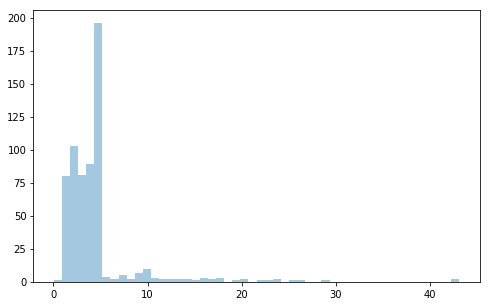

In [47]:
lop_df = example_df[[True if i != '' else False for i in example_df['length_of_project']]]
fig = plt.figure(figsize=(8,5))
lop_list = [i for i in lop_df['length_of_project']]
sns.distplot(lop_list, kde=False)
print(stats.describe(lop_list))
plt.show()

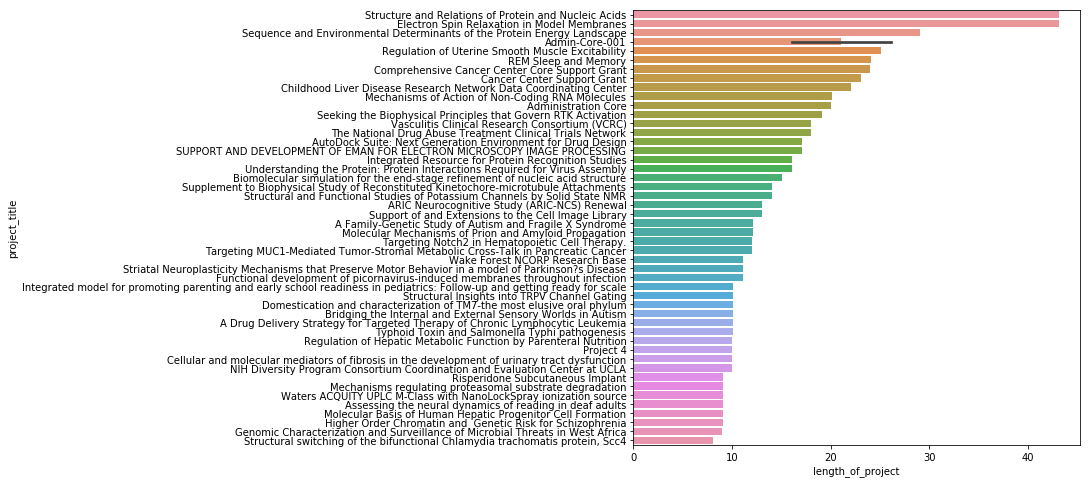

In [48]:
n = 50

trunc_lop_df = lop_df.sort_values('length_of_project', ascending=False).iloc[0:n, :]


fig = plt.figure(figsize=(8,8))
sns.barplot(trunc_lop_df['length_of_project'], trunc_lop_df['project_title'])
plt.show()


### Mean org distribution

Text(0.5, 0, "Organization's Mean Length of Project")

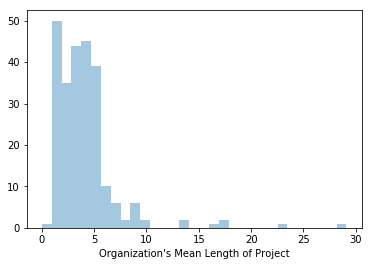

In [49]:
org_group_lop_df = lop_df[['org_name', 'length_of_project']].groupby('org_name').agg(['sum', 'count'])
org_group_lop_df['mean'] = org_group_lop_df['length_of_project']['sum'] / org_group_lop_df['length_of_project']['count']

sns.distplot(org_group_lop_df['mean'], kde=False)
plt.xlabel('Organization\'s Mean Length of Project')

### Longest orgs on average

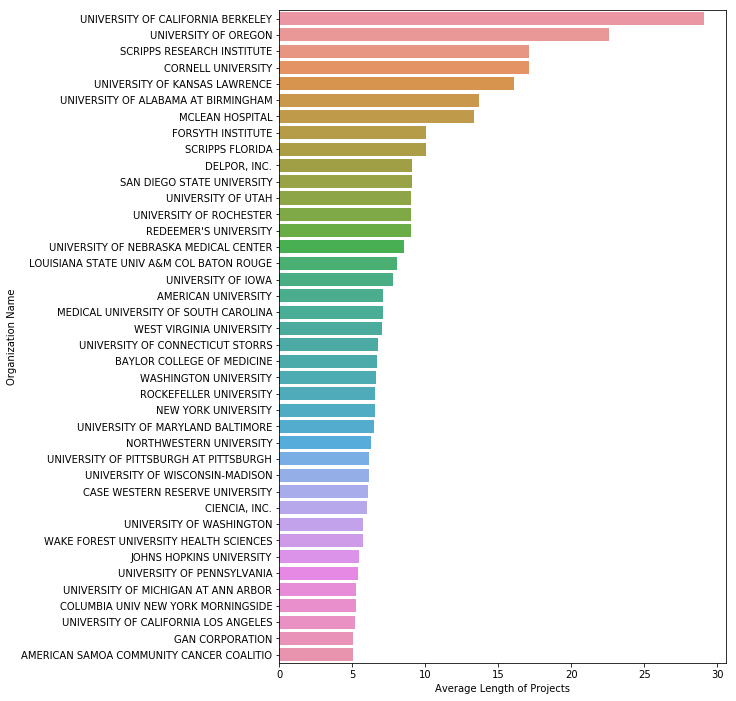

In [50]:
n = 40

trunc_group_lop_df = org_group_lop_df.sort_values('mean', ascending=False).iloc[0:n, :]


fig = plt.figure(figsize=(8,12))
sns.barplot(trunc_group_lop_df['mean'], trunc_group_lop_df.index)
plt.xlabel('Average Length of Projects')
plt.ylabel('Organization Name')
plt.show()


### Quickest Average Orgs

In [ ]:
n = 40
trunc_group_lop_df = org_group_lop_df.sort_values('mean', ascending=True).iloc[0:n, :]


fig = plt.figure(figsize=(8,12))
sns.barplot(trunc_group_lop_df['mean'], trunc_group_lop_df.index)
plt.xlabel('Average Length of Projects')
plt.ylabel('Organization Name')
plt.show()


### Top average institutes

In [ ]:
ic_group_lop_df = lop_df[['ic_name', 'length_of_project']].groupby('ic_name').agg(['sum', 'count'])
ic_group_lop_df['mean'] = ic_group_lop_df['length_of_project']['sum'] / ic_group_lop_df['length_of_project']['count']

sns.distplot(ic_group_lop_df['mean'], kde=False, bins=50)

### Top institutes on average

In [ ]:
n = 40

trunc_group_ic_lop_df = ic_group_lop_df.sort_values('mean', ascending=False).iloc[0:n, :]
trunc_group_ic_lop_df.index = [i.replace('NATIONAL', '') for i in trunc_group_ic_lop_df.index]

fig = plt.figure(figsize=(8,12))
sns.barplot(trunc_group_ic_lop_df['mean'], trunc_group_ic_lop_df.index)
plt.xlabel('Average Length of Projects')
plt.ylabel('Institute Name')
plt.show()


## Org_name

In [ ]:
organizations_df = example_df.dropna(axis=0,subset=['org_name'])
uni_pattern = '(UNIVERSITY)|(COLLEGE)|(SCHOOL)|( ?UNIV )|( COL ?)|( SCH ?)'
uni_organizations = [i for i in organizations_df['org_name'] if re.search(uni_pattern, i)]
n_data_rows = len(organizations_df['org_name'])
n_uni_rows = len(uni_organizations)
pct_uni = round(len(uni_organizations) / len(organizations_df['org_name']), 4)
print(f'Number of rows in data : {n_data_rows}\nNumber of College/Universities : {n_uni_rows} ({pct_uni}%)')

### Colleges

In [ ]:
uni_df = organizations_df[[True if re.search(uni_pattern, i) else False for i in organizations_df['org_name']]]

n = 25

uni_counts_dict = collections.Counter(uni_df['org_name'])

top_count_unis = sorted(uni_counts_dict, key=uni_counts_dict.get, reverse=True)[:n]
top_unis_count = [uni_counts_dict[i] for i in top_count_unis]
#uni_counts = uni_counts[uni_counts.keys()[:50]]

fig = plt.figure(figsize=(12,12))

sns.barplot(top_unis_count, top_count_unis)

for i, v in enumerate(top_unis_count):
    plt.gca().text(v+1, i+.1, str(v), fontsize=10)
    
plt.title(f'Top {n} Counts of Project Organizations with University or College in Name')
plt.show()

### Top Companies

In [ ]:
company_df = organizations_df[[False if re.search(uni_pattern, i) else True for i in organizations_df['org_name']]]

print(company_df.shape)

In [ ]:
n = 25

comp_counts_dict = collections.Counter(company_df['org_name'])

top_count_comp = sorted(comp_counts_dict, key=comp_counts_dict.get, reverse=True)[:n]
top_comp_count = [comp_counts_dict[i] for i in top_count_comp]
#uni_counts = uni_counts[uni_counts.keys()[:50]]

fig = plt.figure(figsize=(12,12))

sns.barplot(top_comp_count, top_count_comp)

for i, v in enumerate(top_comp_count):
    plt.gca().text(v+1, i+.1, str(v), fontsize=10)
    
plt.title(f'Top {n} Counts of Project Organizations outside of Academia')
plt.show()

## ic_name

In [ ]:
instit_df = example_df.dropna(axis=0,subset=['ic_name'])

n = 25

ic_name_counts_dict = collections.Counter(instit_df['ic_name'])

top_count_ic_name = sorted(ic_name_counts_dict, key=ic_name_counts_dict.get, reverse=True)[:n]
top_ic_name_count = [ic_name_counts_dict[i] for i in top_count_ic_name]
#uni_counts = uni_counts[uni_counts.keys()[:50]]

fig = plt.figure(figsize=(12,12))

top_count_ic_name = [i.replace('NATIONAL', '') for i in top_count_ic_name]

sns.barplot(top_ic_name_count, top_count_ic_name)

for i, v in enumerate(top_ic_name_count):
    plt.gca().text(v+1, i+.1, str(v), fontsize=10)

plt.show()

### total_cost

#### Feature importances

In [115]:
tc_df = example_df[[True if (i != '') and (i is not None) else False for i in example_df['total_cost']]]

tc_df.total_cost = tc_df.total_cost.astype(int)
#tc_df = tc_df[['total_cost', 'funding_ics', 'org_city', 'org_country', 'org_duns', 'org_dept', 'org_state', 'org_name']]

/usr/local/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


#### total_cost correlation function

In [216]:
def calc_corr_plot(column_name, list_n = 25, plot_n = 25):
    tc_loop_df = pd.DataFrame(tc_df['total_cost'])
    for column in [column_name]:
        print(f'{column} has {len(tc_df[column].unique())} unique values.')
        tc_dummies_df = pd.get_dummies(tc_df[column], prefix=f'{column}')
        tc_loop_df = pd.concat([tc_loop_df, tc_dummies_df], axis=1, sort=False)
        
    print('\nShape of dummies df :', tc_loop_df.shape, '\n')
    
    grouped_tc_df = tc_df.groupby(column_name).agg(['sum', 'count', 'std'])['total_cost']
    grouped_tc_df['mean'] = round(grouped_tc_df['sum'] / grouped_tc_df['count'], 4)
    
    print(f'Top {list_n} Correlated Values in the {column_name} column.')
    print(tc_loop_df.corr()['total_cost'].sort_values(ascending=False)[1:list_n])
    print(f'\nBottom {list_n} Correlated Values in the {column_name} column.')
    print(tc_loop_df.corr()['total_cost'].sort_values(ascending=True)[1:list_n])
    n = 15
    fig = plt.figure(figsize=(8,12))
    
    
    top_keys = tc_loop_df.corr()['total_cost'].sort_values(ascending=False)[1:plot_n].keys()
    top_values = tc_loop_df.corr()['total_cost'].sort_values(ascending=False)[1:plot_n].values
    top_means = [grouped_tc_df.loc[i.replace(column_name + '_', ''), 'mean'] for i in top_keys]
    top_stds = [grouped_tc_df.loc[i.replace(column_name + '_', ''), 'std'] for i in top_keys]
    for i, (v, m, s) in enumerate(zip(top_values, top_means, top_stds)):
        plt.gca().text(v, i, '{:,.2f}'.format(m) + ' ({:,.2f})'.format(s), fontsize=10)
        
    sns.barplot(top_values, top_keys)
    plt.title(f'Values Most Highly Correlated with `total_cost` from {column_name}\nValues on bars are mean `total_cost` by group', pad=10)
    plt.ylabel(f'Top {plot_n} values from {column_name}', labelpad=20)
    plt.show()

##### org_dept

org_dept has 44 unique values.

Shape of dummies df : (579, 44) 

Top 15 Correlated Values in the org_dept column.
org_dept_BIOSTATISTICS & OTHER MATH SCI    0.312565
org_dept_PHYSICAL MEDICINE & REHAB         0.145226
org_dept_OTHER CLINICAL SCIENCES           0.093326
org_dept_ANESTHESIOLOGY                    0.054598
org_dept_UROLOGY                           0.036212
org_dept_INTERNAL MEDICINE/MEDICINE        0.027281
org_dept_PEDIATRICS                        0.026595
org_dept_RADIATION-DIAGNOSTIC/ONCOLOGY     0.019274
org_dept_GENETICS                          0.018971
org_dept_DENTISTRY                         0.015969
org_dept_PUBLIC HEALTH & PREV MEDICINE     0.012680
org_dept_PATHOLOGY                         0.007919
org_dept_VETERINARY SCIENCES               0.005118
org_dept_ENGINEERING (ALL TYPES)           0.004970
Name: total_cost, dtype: float64

Bottom 15 Correlated Values in the org_dept column.
org_dept_BIOCHEMISTRY               -0.040947
org_dept_NONE            

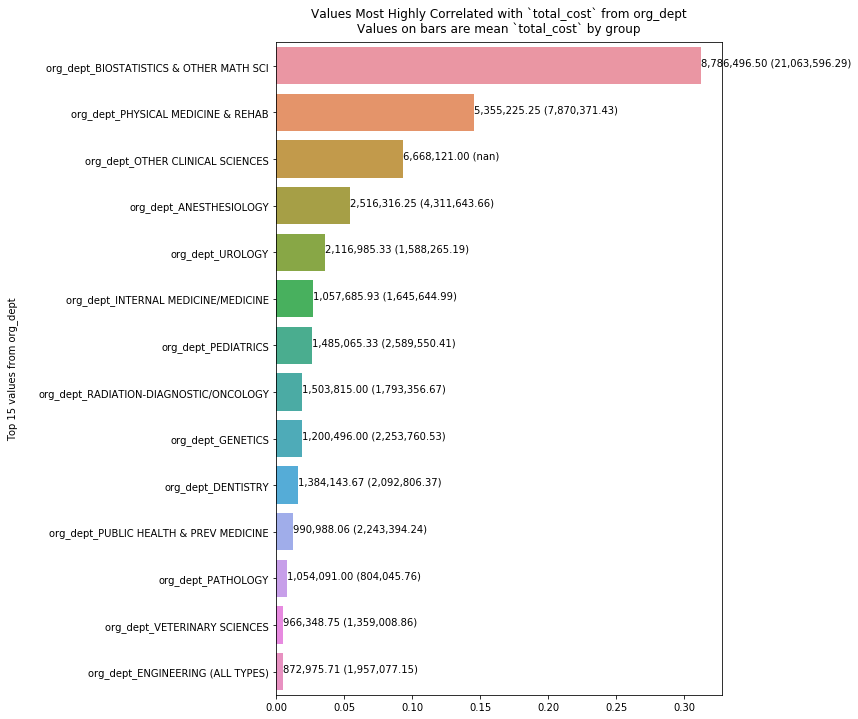

In [217]:
calc_corr_plot('org_dept', list_n = 15, plot_n = 15)

##### org_name

org_name has 248 unique values.

Shape of dummies df : (579, 249) 

Top 15 Correlated Values in the org_name column.
org_name_UNIV OF NORTH CAROLINA CHAPEL HILL                       0.246660
org_name_NATIONAL INSTITUTE OF ALLERGY AND INFECTIOUS DISEASES    0.146370
org_name_UNIVERSITY OF CALIFORNIA SANTA CRUZ                      0.109754
org_name_UNIVERSITY OF ALABAMA AT BIRMINGHAM                      0.103836
org_name_UNIVERSITY OF KENTUCKY                                   0.082689
org_name_BECKMAN RESEARCH INSTITUTE/CITY OF HOPE                  0.076977
org_name_UNIVERSITY OF PUERTO RICO RIO PIEDRAS                    0.076109
org_name_DUKE UNIVERSITY                                          0.071758
org_name_HARVARD UNIVERSITY                                       0.064078
org_name_UNIVERSITY OF HAWAII AT MANOA                            0.059139
org_name_UNIVERSITY OF PITTSBURGH AT PITTSBURGH                   0.057364
org_name_ROSWELL PARK CANCER INSTITUTE CORP               

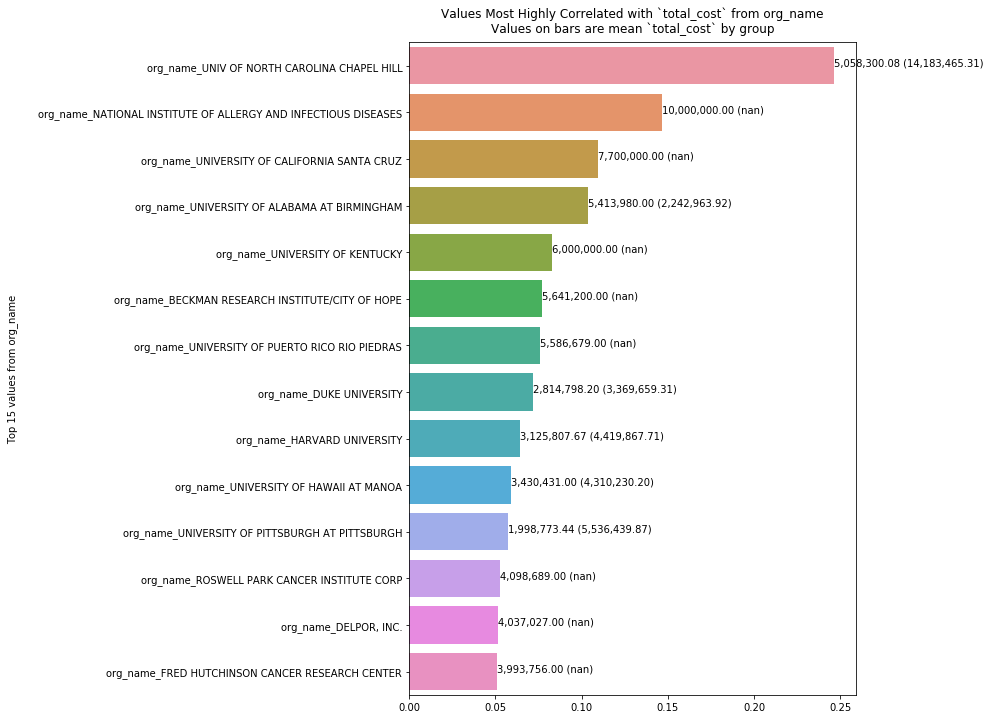

In [218]:
calc_corr_plot('org_name', list_n = 15, plot_n = 15)

##### org_state

org_state has 43 unique values.

Shape of dummies df : (579, 43) 

Top 15 Correlated Values in the org_state column.
org_state_NC    0.200463
org_state_KY    0.082689
org_state_AL    0.071451
org_state_HI    0.059139
org_state_PR    0.043919
org_state_PA    0.028263
org_state_MI    0.028185
org_state_WA    0.024958
org_state_MA    0.003953
org_state_MD   -0.002168
org_state_NM   -0.003624
org_state_IA   -0.003737
org_state_MS   -0.006059
org_state_CT   -0.006098
Name: total_cost, dtype: float64

Bottom 15 Correlated Values in the org_state column.
org_state_NY   -0.030712
org_state_GA   -0.028777
org_state_MN   -0.027959
org_state_IL   -0.027775
org_state_OH   -0.026716
org_state_IN   -0.025118
org_state_TX   -0.023750
org_state_KS   -0.023740
org_state_NH   -0.022097
org_state_MO   -0.022090
org_state_CO   -0.021932
org_state_AZ   -0.018944
org_state_TN   -0.018337
org_state_UT   -0.016934
Name: total_cost, dtype: float64


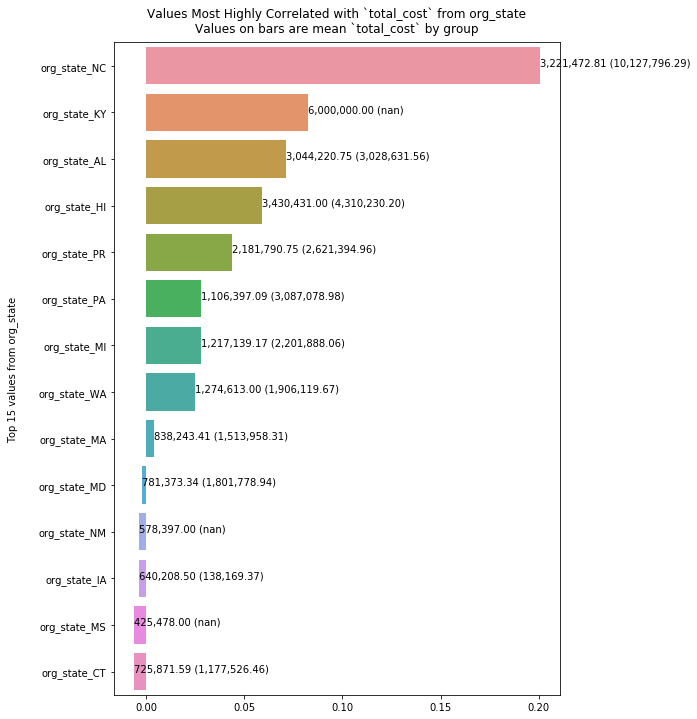

In [219]:
calc_corr_plot('org_state', list_n = 15, plot_n = 15)

##### org_country

org_country has 6 unique values.

Shape of dummies df : (579, 6) 

Top 15 Correlated Values in the org_country column.
org_country_UNITED STATES     0.001051
org_country_SOUTH AFRICA     -0.005459
org_country_NIGERIA          -0.011332
org_country_ETHIOPIA         -0.012556
org_country_UNITED KINGDOM   -0.017478
Name: total_cost, dtype: float64

Bottom 15 Correlated Values in the org_country column.
org_country_ETHIOPIA        -0.012556
org_country_NIGERIA         -0.011332
org_country_SOUTH AFRICA    -0.005459
org_country_UNITED STATES    0.001051
total_cost                   1.000000
Name: total_cost, dtype: float64


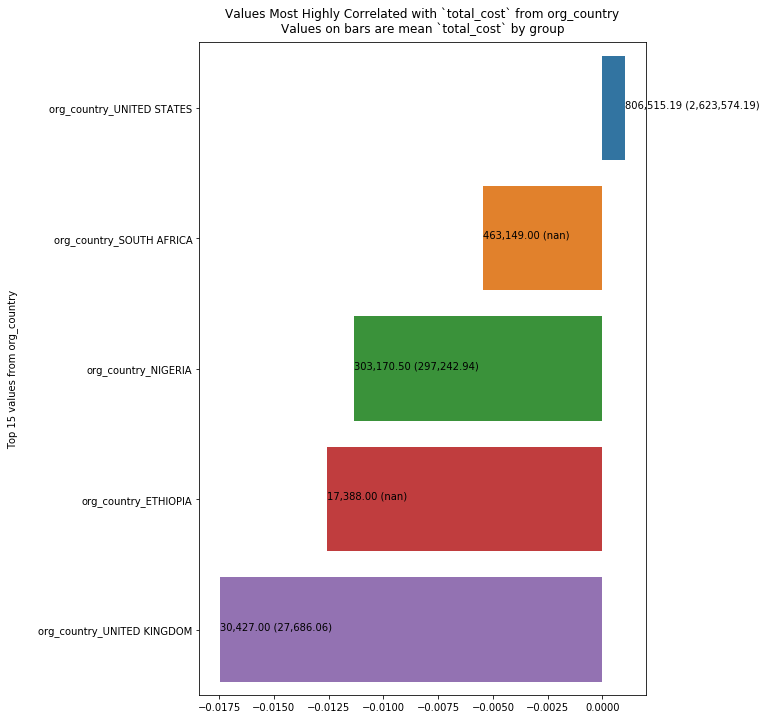

In [220]:
calc_corr_plot('org_country', list_n = 15, plot_n = 15)

##### org_city

org_city has 163 unique values.

Shape of dummies df : (579, 163) 

Top 15 Correlated Values in the org_city column.
org_city_CHAPEL HILL            0.246660
org_city_SANTA CRUZ             0.109754
org_city_BIRMINGHAM             0.103836
org_city_LEXINGTON              0.082689
org_city_DUARTE                 0.076977
org_city_DURHAM                 0.061449
org_city_HONOLULU               0.059139
org_city_SAN JUAN               0.057760
org_city_BUFFALO                0.052420
org_city_PITTSBURGH             0.051512
org_city_SOUTH SAN FRANCISCO    0.051438
org_city_ANN ARBOR              0.044786
org_city_CAMBRIDGE              0.043696
org_city_BELMONT                0.030516
Name: total_cost, dtype: float64

Bottom 15 Correlated Values in the org_city column.
org_city_ROCHESTER      -0.028193
org_city_Chicago        -0.025655
org_city_RICHMOND       -0.025337
org_city_ATLANTA        -0.023980
org_city_BOSTON         -0.023711
org_city_HOUSTON        -0.022021
org_city_GAINESVILL

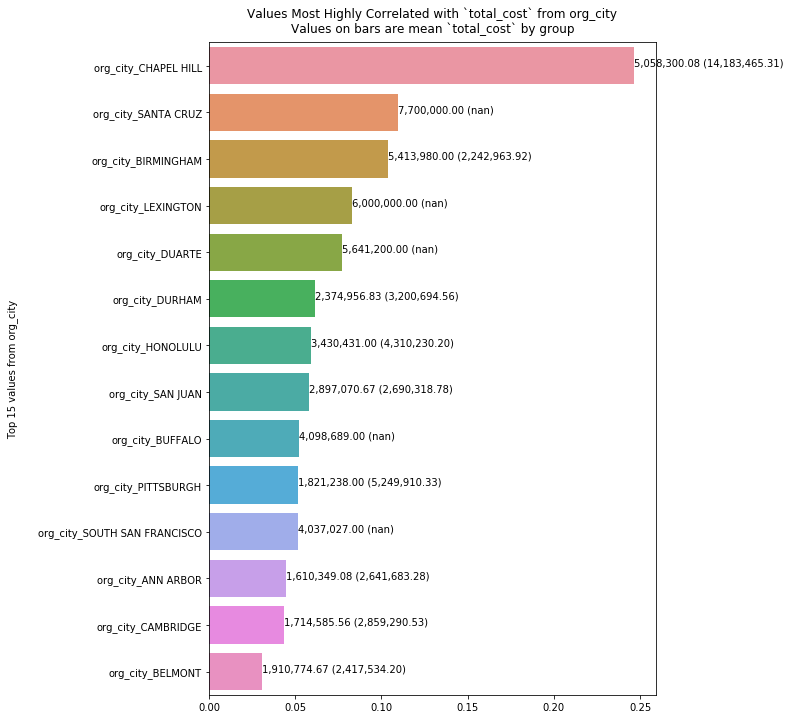

In [221]:
calc_corr_plot('org_city', list_n = 15, plot_n = 15)

##### ic_name

ic_name has 26 unique values.

Shape of dummies df : (579, 27) 

Top 15 Correlated Values in the ic_name column.
ic_name_NATIONAL INSTITUTE OF ARTHRITIS AND MUSCULOSKELETAL AND SKIN DISEASES    0.197374
ic_name_OFFICE OF THE DIRECTOR, NATIONAL INSTITUTES OF HEALTH                    0.188433
ic_name_NATIONAL CANCER INSTITUTE                                                0.069654
ic_name_NATIONAL INSTITUTE ON DRUG ABUSE                                         0.039501
ic_name_National Center for Complementary & Integrative Health                   0.032052
ic_name_NATIONAL INSTITUTE OF ALLERGY AND INFECTIOUS DISEASES                    0.027399
ic_name_NATIONAL INSTITUTE OF DENTAL & CRANIOFACIAL RESEARCH                     0.018526
ic_name_NATIONAL HEART, LUNG, AND BLOOD INSTITUTE                                0.018137
ic_name_NATIONAL CENTER FOR ADVANCING TRANSLATIONAL SCIENCES                     0.017369
ic_name_NATIONAL HUMAN GENOME RESEARCH INSTITUTE                             

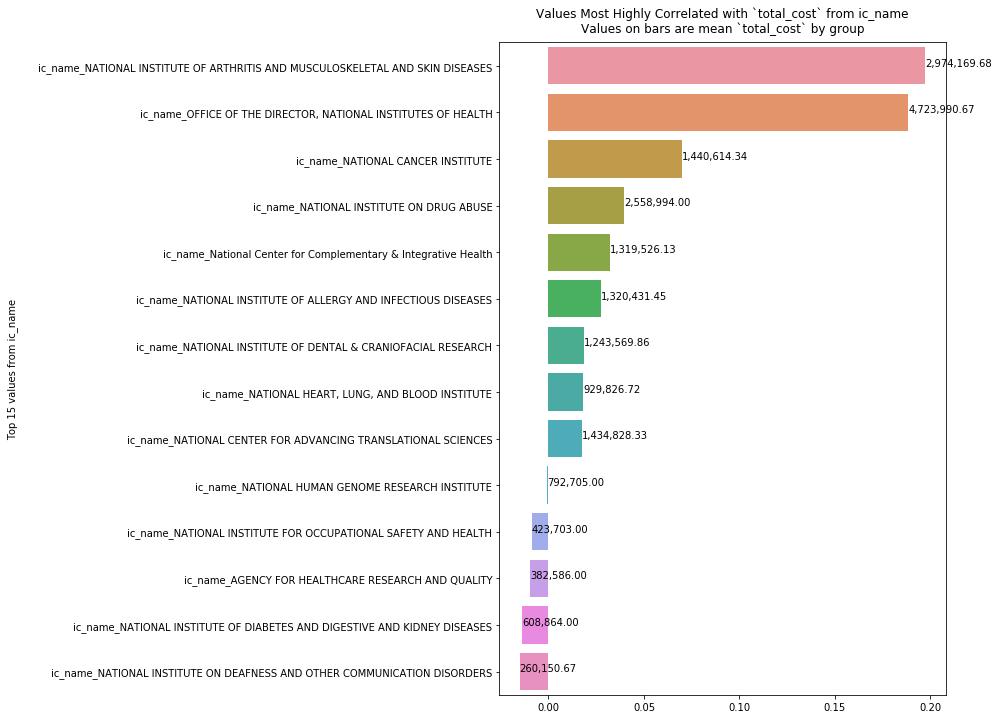

In [187]:
calc_corr_plot('ic_name', list_n = 15, plot_n = 15)